# Plot PCA of Paper

In [2]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-e-16-229.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [3]:
def remove_individuals(df, remove_list=["_d"], iid_col="iid"):
    """Remove indivdiuals from PCA dataframe"""
    idx = df[iid_col].str.contains("|".join(remove_list))
    df = df[~idx].copy()
    print(f"Filtering to {len(df)}/{len(idx)}")
    return df

def get_sub_iid(df, pop_list=[""], iid_col="iid", output=True):
    """Remove indivdiuals from PCA dataframe"""
    pops = "|".join(pop_list)
    idx = df[iid_col].str.contains(pops)
    df = df[idx].copy()
    if output:
        print(f"{pops} IIDs: {len(df)}/{len(idx)}")
    return df

def get_sub_pops(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    pops = "|".join(pop_list)
    idx = df[pop_col].str.contains(pops)
    df = df[idx].copy()
    print(f"{pops} Found: {len(df)}/{len(idx)}")
    return df

def get_sub_pops_exact(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    idx = df[pop_col].isin(pop_list)
    df = df[idx].copy()
    print(f"Found {pop_list} (exact): {len(df)}/{len(idx)}")
    return df

def split_up_df(df, col="loc"):
    """Split up Dataframe by column.
    Return column labels and dataframes"""
    locs = [l for l, _ in df.groupby(col)]
    dfs = [df for _, df in df.groupby(col)]
    return locs, dfs

####################################################
### Plotting PCA

def plot_pca(ax, df, c="gray", alpha=1.0, legend="", marker="o",
             s=30, ec=None, text=False, lw=1):
    """Plot PCA onto Axis"""
    a = ax.scatter(-df["pc1"], df["pc2"], c=c, alpha=alpha, label=legend, 
               ec=ec, s=s, marker=marker, lw=lw)
    if text:
        x, y = -df["pc1"].values, df["pc2"].values
        for i, txt in enumerate(df["iid"]):
            ax.annotate(txt, (x[i], y[i]), ha="left", va="bottom", c=c)
    return a
            
def plot_pca_ho(ax, df, c="gray", alpha=1.0, legend="", marker="o",
                s=30, ec=None, text=False):
    """Plot PCA onto Axis"""
    a = ax.scatter(-df["pc1"], df["pc2"], c=c, alpha=alpha, label=legend, 
               ec=ec, s=s, marker=marker)
    if text:
        x, y = -df["pc1"].values, df["pc2"].values
        for i, txt in enumerate(df["iid"]):
            ax.annotate(txt[:3], (x[i], y[i]), ha="center", va="center")   
    return a
            
###########################################################
### Helper Functions

def return_pca_matches(df, iid="I22119",
                       pcs = ["pc1", "pc2", "pc3", "pc4"]):
    """Return matches in pc space to sample iid.
    Report sorted dataframe"""
    pc_t = df[df["iid"]==iid][pcs]
    diffs = df[pcs]-pc_t.values
    diff_sq = np.sum(diffs**2,axis=1)
    idx = diff_sq.sort_values().index
    return df.iloc[idx,:].copy()

In [4]:
min_snp = 20000
path_pca = "./output/pca/v49.2/20210809.punic.v49.2_HO.construct_WE_NA_PCA.smYES.outitY.evec.txt"
path_meta = "/n/groups/reich/hringbauer/Data/v49.2.anno.csv"

df = pd.read_csv(path_pca, 
                 sep=r"\s+", skiprows=1, header=None)
df.columns=["iid", "pc1", "pc2", "pc3", "pc4", "pop"]
df = remove_individuals(df, remove_list=["_d"])

df_meta = pd.read_csv(path_meta, sep=",")
df2 = df_meta[["iid", "Master ID", "loc", "n_cov_snp", 
               "mean_cov", "sex", "age", "contact", "lat", "lon"]]
df = pd.merge(df, df2, on="iid", how="left")
idx = (df["n_cov_snp"]<min_snp)
df = df[~idx]
df.loc[df["loc"].isnull(), "loc"]="not assigned"
print(f"Filtered to {len(df)} Individuals based on Min SNP: {min_snp}")

df = df.sort_values(by="n_cov_snp", ascending=False)
dup = (df["Master ID"].duplicated() & ~df["Master ID"].isnull())
df = df[~dup].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on duplicates")

idx = df["iid"]=="I22257" # The Sudan Outlier
df=df[~idx].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on manual removals")
#df[df["pop"].str.contains("Lebanon")]

Filtering to 2209/2209
Filtered to 2191 Individuals based on Min SNP: 20000
Filtered to 2119 based on duplicates
Filtered to 2118 based on manual removals


# Prepare the Populations to project

In [5]:
df_ho = get_sub_pops_exact(df, pop_list=["construct_WE_NA_PCA"])
df_is = get_sub_pops_exact(df, pop_list=["Israel_MLBA"])
df_le = get_sub_pops_exact(df, pop_list=["Lebanon_MBA.SG"])
#df_isp = get_sub_pops_exact(df, pop_list=["Israel_Phoenician"])
df_isp = get_sub_pops(df, pop_list=["Israel_Phoenician"])

df_sard = get_sub_pops(df, pop_list=["Italy_Sardinia_Punic"])
df_sard_ba = get_sub_pops_exact(df, pop_list=["Italy_Sardinia_EBA","Italy_Sardinia_BA_Nuragic"])

df_tun = get_sub_pops(df, pop_list=["Tunisia_N", "Tunisia_Mesolithic", "Tunisia_LN"])
df_gua = get_sub_pops(df, pop_list=["Guanche"])

df_vil = get_sub_iid(df, ["VIL"])
df_msr = get_sub_iid(df, ["MSR"])

df_greek = get_sub_pops_exact(df, pop_list=["Greece_BA_Mycenaean"])
df_alg = get_sub_pops(df, pop_list=["Algeria_IA"])
df_spain = get_sub_pops_exact(df, pop_list=["Spain_IA", "Spain_IA_Tartessian", "Spain_IA_Celt", "Spain_IA_Celt.SG"])

df_sic_mba = get_sub_pops_exact(df, pop_list=["Italy_Sicily_MBA"])

df_vill = get_sub_pops(df, pop_list=["Villaricos"], pop_col="loc")
df_vill = df_vill[(df_vill["pop"].str.contains("Punic")) & (df_vill["age"]>2000)]
df_ib = get_sub_pops(df, ["Ibiza_Punic"])
#df_sic = get_sub_pops_exact(df, ["Italy_Phoenician_Sicily"])
df_sic2 = get_sub_pops(df, ["Italy_Sicily_Punic"])
df_mar = df_sic2[df_sic2["loc"].str.contains("Marsala")].copy()
df_mot = df_sic2[df_sic2["loc"].str.contains("Motya")].copy()
df_bir = df_sic2[df_sic2["loc"].str.contains("Birgi")].copy()
df_sel = df_sic2[df_sic2["loc"].str.contains("Selinunte")].copy()
df_pal = df_sic2[df_sic2["loc"].str.contains("Palermo")].copy()

dft = get_sub_pops(df, ["Spain_Punic"])
df_cad = get_sub_pops(df, pop_list=["Cádiz"], pop_col="loc")

df_sic_ia = get_sub_pops_exact(df, ["Italy_Sicily_IA_Polizzello"])
df_sic_him = get_sub_pops(df, ["Sicily_Himera"])

df_eg_hell = get_sub_pops(df, ["Egypt_Hellenistic"])
df_eg_dyn = get_sub_pops(df, ["Egypt_Dynastic"])
df_meno = get_sub_pops(df, ["Menorca"])
#df_kerk = get_sub_pops(df, ["Tunisia_Pun"])

Found ['construct_WE_NA_PCA'] (exact): 1187/2118
Found ['Israel_MLBA'] (exact): 35/2118
Found ['Lebanon_MBA.SG'] (exact): 5/2118
Israel_Phoenician Found: 13/2118
Italy_Sardinia_Punic Found: 18/2118
Found ['Italy_Sardinia_EBA', 'Italy_Sardinia_BA_Nuragic'] (exact): 28/2118
Tunisia_N|Tunisia_Mesolithic|Tunisia_LN Found: 7/2118
Guanche Found: 5/2118
VIL IIDs: 6/2118
MSR IIDs: 2/2118
Found ['Greece_BA_Mycenaean'] (exact): 14/2118
Algeria_IA Found: 1/2118
Found ['Spain_IA', 'Spain_IA_Tartessian', 'Spain_IA_Celt', 'Spain_IA_Celt.SG'] (exact): 25/2118
Found ['Italy_Sicily_MBA'] (exact): 4/2118
Villaricos Found: 14/2118
Ibiza_Punic Found: 1/2118
Italy_Sicily_Punic Found: 43/2118
Spain_Punic Found: 29/2118
Cádiz Found: 4/2118
Found ['Italy_Sicily_IA_Polizzello'] (exact): 19/2118
Sicily_Himera Found: 30/2118
Egypt_Hellenistic Found: 3/2118
Egypt_Dynastic Found: 2/2118
Menorca Found: 5/2118


### Save the Plots for PCA

In [13]:
df_is["color"]="blue"
df_greek["color"]="skyblue"
df_spain["color"]="gray"
df_sard_ba["color"]="lime"
df_sic_ia["color"]="green"
df_sic_mba["color"]="olive"
df_tun["color"]="yellow"
df_gua["color"]="sienna"
df_meno["color"]="lightgray"
df_eg_hell["color"]="tan"

df_save = pd.concat((df_is, df_greek, df_spain, df_sard_ba, df_sic_ia,
               df_sic_mba, df_tun, df_gua, df_meno, df_eg_hell))

savepath = "./output/tables/reference_samples_plot.v49.2.tsv"
df_save.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(df_save)} reference Samples to: {savepath}")

Saved 145 reference Samples to: ./output/tables/reference_samples_plot.v49.2.tsv


# Panels for the PCA

## Context

Saved to: ./figures/pca.v49.2/context.pdf


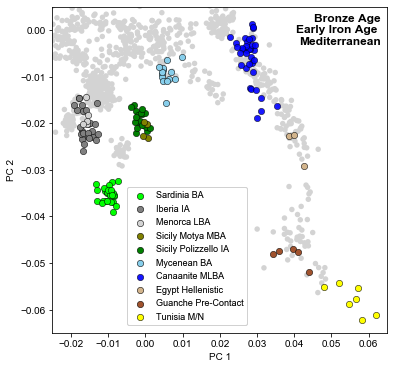

In [38]:
savepath="./figures/pca.v49.2/context.pdf"

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
l1 = plot_pca(ax, df_is, c="blue", legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, c="skyblue", legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, c="gray", legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, c="lime", legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, c="green", legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, c="olive", legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, c="yellow", legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, c="sienna", legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, c="lightgray", legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, c="tan", legend="", s=s, ec=ec, lw=lw)


labels = ["Sardinia BA", "Iberia IA", "Menorca LBA", "Sicily Motya MBA", "Sicily Polizzello IA", 
          "Mycenean BA", "Canaanite MLBA", "Egypt Hellenistic", "Guanche Pre-Contact",
          "Tunisia M/N"]

plots = [l4, l3, l9, l6, l5, l2, l1, l10, l8, l7]
leg1 = ax.legend(plots, labels, fontsize=9,
          bbox_to_anchor=(0.21, 0.01), loc="lower left")

ax.add_artist(leg1)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.065])
ax.set_ylim([-0.065,0.005])

### Title left top:
ax.text(0.98, 0.98, "Bronze Age\nEarly Iron Age \nMediterranean", weight='bold',
        ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

## Early Punic

Saved to: ./figures/pca.v49.2/early_punic.pdf


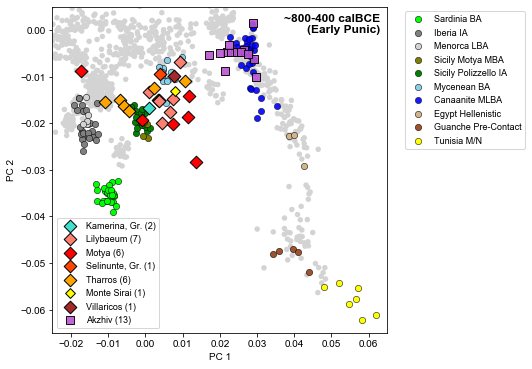

In [6]:
savepath="./figures/pca.v49.2/early_punic.pdf"

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
l1 = plot_pca(ax, df_is, c="blue", legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, c="skyblue", legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, c="gray", legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, c="lime", legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, c="green", legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, c="olive", legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, c="yellow", legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, c="sienna", legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, c="lightgray", legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, c="tan", legend="", s=s, ec=ec, lw=lw)


labels = ["Sardinia BA", "Iberia IA", "Menorca LBA", "Sicily Motya MBA", "Sicily Polizzello IA", 
          "Mycenean BA", "Canaanite MLBA", "Egypt Hellenistic", "Guanche Pre-Contact",
          "Tunisia M/N"]

plots = [l4, l3, l9, l6, l5, l2, l1, l10, l8, l7]
leg1 = ax.legend(plots, labels, fontsize=9,
          bbox_to_anchor=(1.04,1), loc="upper left")

### Plot the early Punic Samples
s=80
df_iid = get_sub_iid(df, ["I14915", "I19532"], output=False)
a1 = plot_pca(ax, df_iid, c="turquoise", legend="", ec="k", s=s, marker="D")

df_iid = get_sub_iid(df, ["I12666|I12847|I24678|I24676|I24675|I24556|I22095"], output=False)
a2 = plot_pca(ax, df_iid, c="salmon", legend="", ec="k", s=s, marker="D")

df_iid = get_sub_iid(df, ["I4798|I4799|I4800|I7762|I22236|I22232"], output=False)
a3 = plot_pca(ax, df_iid, c="red", legend="", ec="k", s=s, marker="D")

df_iid = get_sub_iid(df, ["I21853"], output=False)
a4 = plot_pca(ax, df_iid, c="orangered", legend="", ec="k", s=s, marker="D")

df_iid = get_sub_iid(df, ["I22115", "I22121", "I22096", 
                          "I22122", "I22118", "I22117"], output=False)
a5 = plot_pca(ax, df_iid, c="orange", legend="", 
         ec="k", s=s, marker="D")

df_iid = get_sub_iid(df, ["I18201"], output=False)
a6 = plot_pca(ax, df_iid, c="brown", 
         legend="", ec="k", s=s, marker="D")

a7 = plot_pca(ax, df_isp, c="mediumorchid", 
         legend="", ec=ec, alpha=0.9, s=s, marker="s")

df_iid = get_sub_iid(df, ["MSR002"], output=False)
a8 = plot_pca(ax, df_iid, c="yellow",
         legend="", ec="k", s=s*0.6, marker="D")

plots = [a1, a2, a3, a4, a5, a8, a6, a7]
legs = ["Kamerina, Gr. (2)", "Lilybaeum (7)",
        "Motya (6)", "Selinunte, Gr. (1)", "Tharros (6)",
        "Monte Sirai (1)", "Villaricos (1)", "Akzhiv (13)"]
ax.legend(plots, legs, fontsize=9, loc="lower left",
         title="")

ax.add_artist(leg1)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.065])
ax.set_ylim([-0.065,0.005])

### Title left top:
ax.text(0.98, 0.98, "~800-400 calBCE\n(Early Punic)", weight='bold',
        ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

### Peak Punic [400-200 BCE]

Saved to: ./figures/pca.v49.2/late_punic.pdf


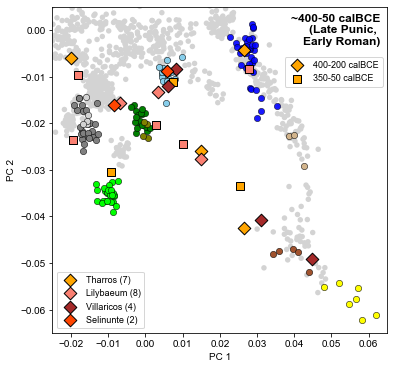

In [40]:
savepath="./figures/pca.v49.2/late_punic.pdf"

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
l1 = plot_pca(ax, df_is, c="blue", legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, c="skyblue", legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, c="gray", legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, c="lime", legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, c="green", legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, c="olive", legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, c="yellow", legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, c="sienna", legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, c="lightgray", legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, c="tan", legend="", s=s, ec=ec, lw=lw)

### Plot the early Punic Samples
s=80

### Tharros
df_iid = get_sub_iid(df, ["I22114|I22119|I21966|I22093"], output=False) # 400-200 calBCE
a1 = plot_pca(ax, df_iid, c="orange", legend="Tharros 400-200 calBCE (4)", 
         ec="k", s=80, marker="D")
df_iid = get_sub_iid(df, ["I22113|I22125|I22088"], output=False) # 400-200 calBCE
b1 = plot_pca(ax, df_iid, c="orange", legend="Tharros 350-50 calBCE (4)", 
         ec="k", s=80, marker="s")

### Lilybaeum
df_iid = get_sub_iid(df, ["I24555", "I12848", "I21857"], output=False)
a2 = plot_pca(ax, df_iid, c="salmon", legend="Lilybaeum 400-200 calBCE (3)", 
              ec="k", s=80, marker="D")

df_iid = get_sub_iid(df, ["I12665", "I21859", "I12846", "I8577", "I7454"], output=False)
b2 = plot_pca(ax, df_iid, c="salmon", legend="Lilybaeum 350-50 calBCE (5)", 
              ec="k", s=80, marker="s")

### Villaricos
df_iid = get_sub_iid(df, ["I18193", "I18189", "I18199", "I18203"], output=False)
a3 = plot_pca(ax, df_iid, c="brown", legend="Villaricos 400-200 calBCE (4)", 
              ec="k", s=80, marker="D")

df_iid = get_sub_iid(df, ["I21197", "I21855"], output=False)
a4 = plot_pca(ax, df_iid, c="orangered", legend="Selinunte 400-200 calBCE (2)", 
              ec="k", s=80, marker="D")

plots = [a1, b1]
legs = ["400-200 calBCE", "350-50 calBCE"]
leg1 = ax.legend(plots, legs, fontsize=9,  
                 bbox_to_anchor=(0.68, 0.86), loc="upper left", title="")

plots = [a1, a2, a3, a4]
legs = ["Tharros (7)", "Lilybaeum (8)",
        "Villaricos (4)", "Selinunte (2)"]

ax.legend(plots, legs, fontsize=9, loc="lower left",
         title="")
ax.add_artist(leg1)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.065])
ax.set_ylim([-0.065,0.005])

### Title left top:
ax.text(0.98, 0.98, "~400-50 calBCE\n(Late Punic, \nEarly Roman)", weight='bold',
        ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

### Roman times

Saved to: ./figures/pca.v49.2/roman.pdf


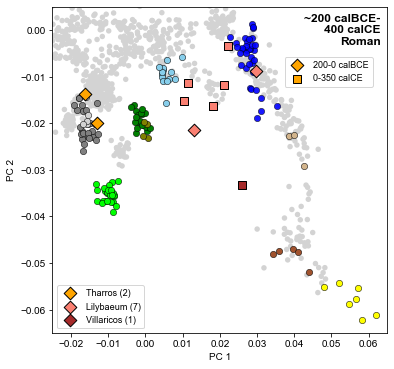

In [43]:
#savepath="./figures/pca.v49.2/late_punic.pdf"
savepath="./figures/pca.v49.2/roman.pdf"

plt.figure(figsize=(6,6))
ax = plt.gca()

### Plot Context
lw=0.5
ec="k"
s=40

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
l1 = plot_pca(ax, df_is, c="blue", legend="", ec=ec, alpha=0.9, s=40, lw=lw)
l2 = plot_pca(ax, df_greek, c="skyblue", legend="", ec=ec, s=s, lw=lw)
l3 = plot_pca(ax, df_spain, c="gray", legend="", s=s, ec=ec, lw=lw)
l4 = plot_pca(ax, df_sard_ba, c="lime", legend="", ec=ec, s=s, lw=lw)
l5 = plot_pca(ax, df_sic_ia, c="green", legend="", s=s, ec=ec, lw=lw)
l6 = plot_pca(ax, df_sic_mba, c="olive", legend="", s=s, ec=ec, lw=lw)
l7 = plot_pca(ax, df_tun, c="yellow", legend="", ec=ec, s=s, lw=lw)
l8 = plot_pca(ax, df_gua, c="sienna", legend="", s=s, ec=ec, lw=lw)
l9 = plot_pca(ax, df_meno, c="lightgray", legend="", s=s, ec=ec, lw=lw)
l10 = plot_pca(ax, df_eg_hell, c="tan", legend="", s=s, ec=ec, lw=lw)

### Plot the early Punic Samples
s=80

### Tharros
df_iid = get_sub_iid(df, ["I21964|I22112"], output=False) # 400-200 calBCE
a1 = plot_pca(ax, df_iid, c="orange", legend="Tharros 200-0 calBCE (4)", 
         ec="k", s=s, marker="D")
df_iid = get_sub_iid(df, ["I22091"], output=False) # 400-200 calBCE
b1 = plot_pca(ax, df_iid, c="orange", legend="Tharros 0-350 calCE (4)", 
         ec="k", s=s, marker="s")


### Lilybaeum
df_iid = get_sub_iid(df, ["I12844", "I24554"], output=False)
a2 = plot_pca(ax, df_iid, c="salmon", legend="Lilybaeum 200-0 calBCE (2)", 
              ec="k", s=s, marker="D")

df_iid = get_sub_iid(df, ["I12664", "I12849", "I7265", 
                          "I21970", "I24680", "I24557"], output=False)
b2 = plot_pca(ax, df_iid, c="salmon", legend="Lilybaeum 0-400 calCE (5)", 
              ec="k", s=s, marker="s")

### Villaricos
#df_iid = get_sub_iid(df, ["XXXXXXXX"], output=False)
#a3 = plot_pca(ax, df_iid, c="brown", legend="Villaricos 200-0 calBCE  (0))", 
#              ec="k", s=s, marker="D")

df_iid = get_sub_iid(df, ["I18198", "I18400"], output=False)
b3 = plot_pca(ax, df_iid, c="brown", legend="Villaricos 0-400 calCE (2))", 
              ec="k", s=80, marker="s")

plots = [a1, b1]
legs = ["200-0 calBCE", "0-350 calCE"]
leg1 = ax.legend(plots, legs, fontsize=9,  
                 bbox_to_anchor=(0.68, 0.86), loc="upper left", title="")

plots = [a1, a2, a3, a4]
legs = ["Tharros (2)", "Lilybaeum (7)", "Villaricos (1)"]

ax.legend(plots, legs, fontsize=9, loc="lower left", title="")
ax.add_artist(leg1)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.065])
ax.set_ylim([-0.065,0.005])

### Title left top:
ax.text(0.98, 0.98, "~200 calBCE-\n400 calCE\nRoman", 
        weight='bold',  ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

df_t

In [44]:
df_iid

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,n_cov_snp,mean_cov,sex,age,contact,lat,lon
462,I18400,-0.025838,-0.03326,-0.023087,-0.039055,Spain_Vandal_Visigoth_oAfrica1,I18400,"Almería, Cuevas del Almazora, Villaricos",438379.0,0.365316,F,1585.0,"Lalueza-Fox, Carles",37.247,-1.7768
